<a href="https://colab.research.google.com/github/cserock/colab-examples/blob/main/05_SAM_%EC%9E%90%EB%8F%99_%EB%A7%88%EC%8A%A4%ED%81%AC_%EC%83%9D%EC%84%B1_%EC%98%88%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatically generating object masks with SAM

이 노트북은 facebook/segment-anything의 마스크 생성기 예제를 Keras 3.0으로 포팅한 것입니다.

SAM은 프롬프트를 효율적으로 처리할 수 있으므로, 이미지 전체에 대해 많은 수의 프로프트를 샘플링하여 마스크를 생성할 수 있습니다. 이 방법은 SA-1B 데이터셋 생성에 사용되었습니다.

SAMAutomaticMaskGenerator 클래스는 이 기능을 구현한 것으로, 이미지 위에 그리드 형태로 단일 포인트 입력 프로프트를 샘플링합니다. 각 포인트에서 SAM이 여러 개의 마스크를 예측할 수 있습니다. 이후 마스크는 품질 기준으로 필터링되고 비최대 억제(non-maximal suppression)를 이용해 중복 제거됩니다. 추가 옵션으로 이미지의 여러 크롭에서 예측을 수행하거나, 마스크의 작은 분리 영역과 구멍을 제거하는 후처리 과정을 통해 마스크 품질과 수량을 향상시킬 수 있습니다.

이 방법은 고품질의 객체 분할 마스크를 자동으로 생성하는 데 유용하며, 유연한 마스크 생성 워크플로우를 제공합니다.

In [ ]:
# Get the dependencies
!pip install -Uq keras-cv >> /dev/null
!pip install -Uq keras >> /dev/null
!pip install -Uq git+https://github.com/tirthasheshpatel/segment_anything_keras.git >> /dev/null

# Get the image for the demo
!curl -sSL https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg -o dog.jpg

In [ ]:
import os
os.environ['KERAS_BACKEND'] = "tensorflow"

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras_cv.models import SegmentAnythingModel
from sam_keras import SAMAutomaticMaskGenerator, SAMPredictor

In [ ]:
# Define the huge model in KerasCV
model = SegmentAnythingModel.from_preset("sam_huge_sa1b")
predictor = SAMPredictor(model)

100%|██████████| 3.38k/3.38k [00:00<00:00, 5.99MB/s]


100%|██████████| 2.39G/2.39G [02:33<00:00, 16.7MB/s]


In [ ]:
image = cv2.imread('dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

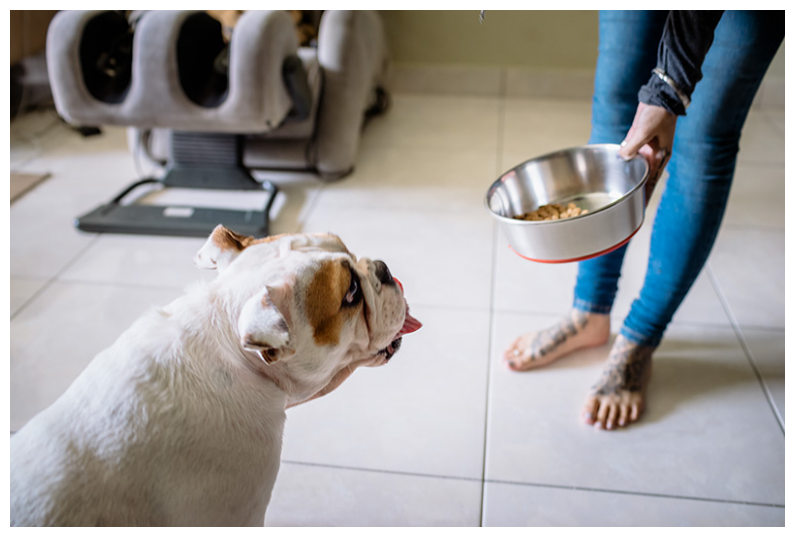

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

## 자동 마스크 생성

자동 마스크 생성을 실행하려면 SAM 모델을 `SAMAutomaticMaskGenerator 클래스에 제공해야 합니다. 아래 경로는 SAM 체크포인트로 설정합니다.

In [ ]:
mask_generator = SAMAutomaticMaskGenerator(predictor)

In [ ]:
masks = mask_generator.generate(image, verbose=0)

마스크 생성은 마스크 리스트를 반환하며, 각 마스크는 마스크에 대한 다양한 데이터를 포함하는 딕셔너리 형태입니다. 이 딕셔너리의 주요 키는 다음과 같습니다.

- `segmentation` : the mask
- `area` : the area of the mask in pixels
- `bbox` : the boundary box of the mask in XYWH format
- `predicted_iou` : the model's own prediction for the quality of the mask
- `point_coords` : the sampled input point that generated this mask
- `stability_score` : an additional measure of mask quality
- `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
print(len(masks))
print(masks[0].keys())

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

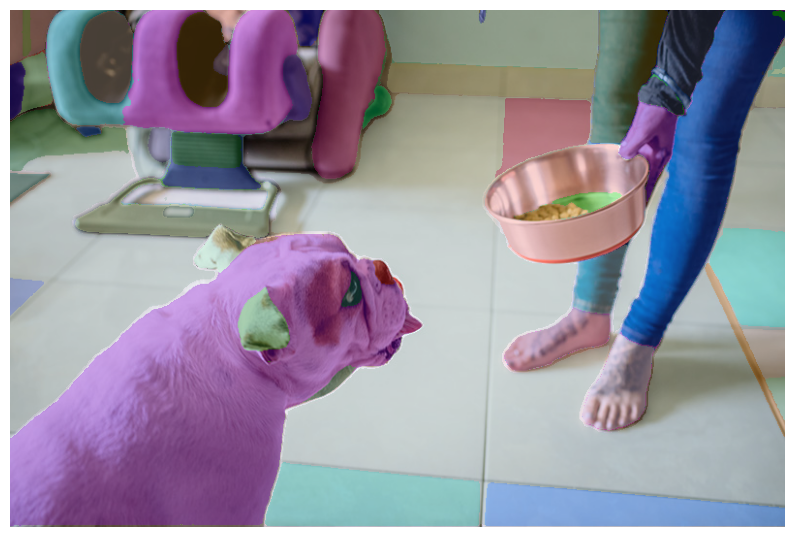

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## 자동 마스크 생성 옵션

자동 마스크 생성에는 포인트를 얼마나 촘촘히 샘플링할지, 낮은 품질이나 중복된 마스크를 제거하기 위한 임계값을 조절하는 여러 매개변수가 있습니다. 추가로, 이미지의 크롭된 부분에서 자동 생성이 실행되어 작은 객체에 대해 성능이 향상될 수 있으며, 후처리로 떠돌이 픽셀이나 구멍을 제거할 수 있습니다. 다음은 더 많은 마스크를 샘플링하는 구성 예시입니다.

이 옵션들을 통해 마스크 생성의 밀도와 품질을 조정할 수 있으며, 다양한 이미지 상황에 맞게 유연하게 적용할 수 있습니다. 특히 작은 객체 검출을 향상시키고, 불필요한 노이즈를 줄이면서 보다 정밀한 마스크를 얻는 데 중요한 역할을 합니다.

In [ ]:
mask_generator_2 = SAMAutomaticMaskGenerator(
    predictor=predictor,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image, verbose=0)

In [ ]:
len(masks2)

87

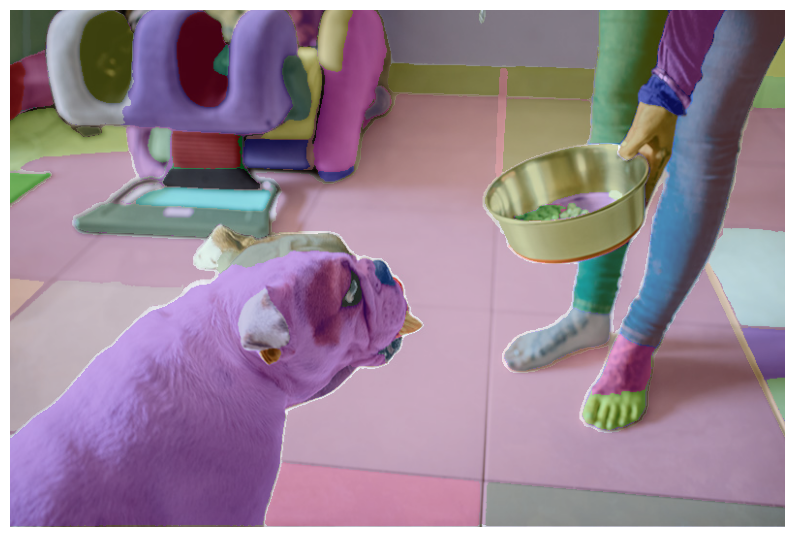

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()